# Learned dynamical systems (DS)
Work in progress

In [1]:
# Import the libSIA python bindings and numpy
import pysia as sia
import numpy as np

# Import plotting helpers
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_theme(style="whitegrid")

# Set the generator instance seed for repeatability
generator = sia.Generator.instance()

In [6]:
generator.seed(10)

# Create the dynamical systems
A = {
    "Case 1: Spiral (Stable)": np.array([[0, -1], [1, -1]]),
    "Case 2: Saddle Point (Unstable)": np.array([[0, 1], [1, 0]]),
    "Case 3: Degenerate Node (Stable)": np.array([[-1, 1], [0, -1]]),
}
ns = len(A)
Qpsd = 1e-4 * np.diag([1, 1])
B = np.array([[0], [0]])
dt = 0.1
ds = [sia.LinearGaussianDynamicsCT(list(A.values())[i], B, Qpsd, dt) for i in range(ns)]

# Simulate a few trials
Ntrials = 5
T = 3
t = np.arange(0, T, dt)
n = len(t)
X = [np.zeros((2, n * Ntrials)) for i in range(ns)]
Xp = [np.zeros((2, n * Ntrials)) for i in range(ns)]
gaussian = sia.Gaussian(2)
for i in range(ns):
    for j in range(Ntrials):
        j0 = n * j
        x = np.zeros((2, n + 1))
        x[:, 0] = gaussian.sample()
        for k in range(n):
            x[:, k + 1] = ds[i].dynamics(x[:, k], np.zeros(1)).sample()
        X[i][:, j0:n+j0] = x[:, :-1]
        Xp[i][:, j0:n+j0] = x[:, 1:]

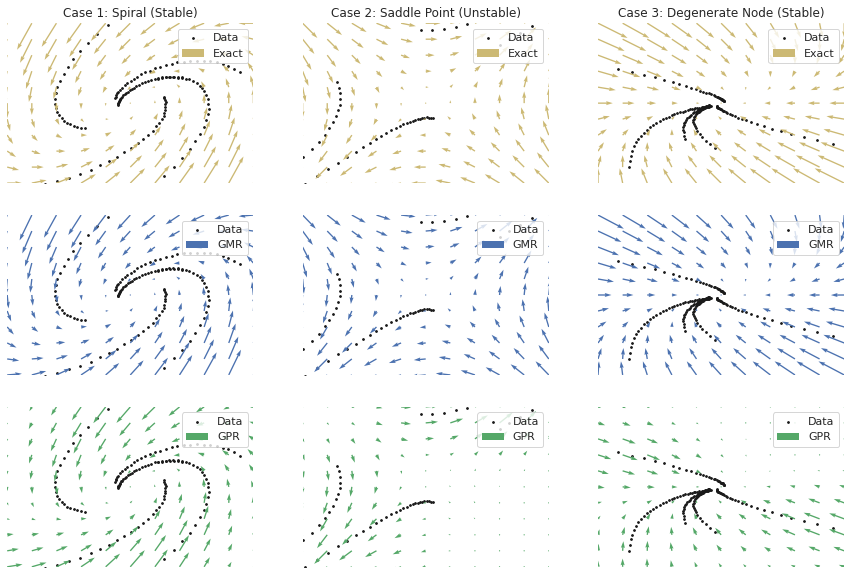

In [7]:
# Fit models and plot the result
xr = (-1.5, 1.5)
nx = 11
xx = np.linspace(xr[0], xr[1], nx)
x1, x2 = np.meshgrid(xx, xx)
xt = np.vstack((x1.flatten(), x2.flatten()))
f, ax = plt.subplots(nrows=3, ncols=ns, figsize=(15, 10))
sns.despine(f, left=True, bottom=True)
for i in range(ns):
    x = X[i]
    y = (Xp[i] - X[i]) / dt
    
    # Model 0. Ground truth vector field
    yt0 = np.zeros(np.shape(xt))
    for j in range(np.shape(xt)[1]):
        yt0[:, j] = list(A.values())[i] @ xt[:, j]
    ax[0, i].scatter(x[0, :], x[1, :], s=3, c="k", label="Data")
    ax[0, i].quiver(xt[0, :], xt[1, :], yt0[0, :], yt0[1, :], color='y', scale=25, label="Exact")
    ax[0, i].set_title(list(A.keys())[i])
    
    # Model 1. Create a GMR
    xy = np.vstack((x, y))
    gmm = sia.GMM(xy, K=1, regularization=1e-6)
    gmr = sia.GMR(gmm, input_indices=[0, 1], output_indices=[2, 3])
    yt1 = np.zeros(np.shape(xt))
    for j in range(np.shape(xt)[1]):
        yt1[:, j] = gmr.predict(xt[:, j]).mean()
    ax[1, i].scatter(x[0, :], x[1, :], s=3, c="k", label="Data")
    ax[1, i].quiver(xt[0, :], xt[1, :], yt1[0, :], yt1[1, :], color='b', scale=25, label="GMR")

    # Model 2. Create a GPR
    gpr = sia.GPR(x, y, varf=1.0, varn=0.1, length=0.5)
    yt2 = np.zeros(np.shape(xt))
    for j in range(np.shape(xt)[1]):
        yt2[:, j] = gpr.predict(xt[:, j]).mean()
    ax[2, i].scatter(x[0, :], x[1, :], s=3, c="k", label="Data")
    ax[2, i].quiver(xt[0, :], xt[1, :], yt2[0, :], yt2[1, :], color='g', scale=25, label="GPR")
    
    for j in range(3):
        ax[j, i].set_xlim(xr)
        ax[j, i].set_ylim(xr)
        ax[j, i].axis('off')
        ax[j, i].legend(loc='upper right')